In [76]:
import numpy as np
import matplotlib.pyplot as plt

def fill_nan_multifocal_from_derivatives_viz(
        fx, fy, X, Y,
        nbins=200, smooth_win=5,
        edge_threshold_factor=1.2,
        max_R_factor=10.0,
        show_plots=True,
        verbose=True):
    """
    Восстановление выбитых областей в fx, fy и визуализация.
    """

    eps = 1e-12
    assert fx.shape == fy.shape == X.shape == Y.shape

    # радиальная координата и единичные радиальные векторы
    r = np.sqrt(X**2 + Y**2)
    max_r = np.nanmax(r)
    ux = np.zeros_like(X)
    uy = np.zeros_like(Y)
    mask_nonzero = r > 0
    ux[mask_nonzero] = X[mask_nonzero] / r[mask_nonzero]
    uy[mask_nonzero] = Y[mask_nonzero] / r[mask_nonzero]

    # радиальная производная f_r = fx*ux + fy*uy
    fr = np.zeros_like(fx)
    fr[:] = np.nan
    valid = ~np.isnan(fx) & ~np.isnan(fy)
    fr[valid] = fx[valid] * ux[valid] + fy[valid] * uy[valid]

    # радиальные бины
    r_flat = r.flatten()
    fr_flat = fr.flatten()
    valid_flat = ~np.isnan(fr_flat)
    r_valid = r_flat[valid_flat]
    fr_valid = fr_flat[valid_flat]

    bin_edges = np.linspace(0.0, max_r + 1e-9, nbins + 1)
    bin_idx = np.digitize(r_valid, bin_edges) - 1
    rcenters = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    radial_profile = np.full(nbins, np.nan)
    for b in range(nbins):
        sel = bin_idx == b
        if np.any(sel):
            radial_profile[b] = np.median(fr_valid[sel])

    # сглаживание
    if smooth_win > 1:
        w = np.ones(smooth_win) / smooth_win
        pad = smooth_win // 2
        arr = np.pad(np.nan_to_num(radial_profile, nan=0.0), (pad, pad), mode='edge')
        smoothed = np.convolve(arr, w, mode='valid')
        radial_profile_sm = smoothed
    else:
        radial_profile_sm = radial_profile.copy()

    # поиск разрывов
    diff = np.abs(np.diff(radial_profile_sm))
    diff_nonan = diff[~np.isnan(diff)]
    mean_d = np.mean(diff_nonan)
    std_d = np.std(diff_nonan)
    threshold = mean_d + edge_threshold_factor * std_d
    edge_bins = np.where(diff > threshold)[0]
    r_edges = list(rcenters[edge_bins])
    r_edges_full = [0.0] + r_edges + [max_r + 1e-6]
    if verbose:
        print("Найдено ступенек:", len(r_edges_full) - 1)

    # оценка радиусов ступеней
    R_list = []
    r_intervals = []
    for i in range(len(r_edges_full)-1):
        r_lo, r_hi = r_edges_full[i], r_edges_full[i+1]
        sel = (r_valid >= r_lo) & (r_valid < r_hi)
        if not np.any(sel):
            R_list.append(np.nan)
            r_intervals.append((r_lo, r_hi))
            continue
        r_seg = r_valid[sel]
        fr_seg = fr_valid[sel]
        fr_abs = np.abs(fr_seg)
        good = fr_abs > 1e-8
        if np.count_nonzero(good) < 3:
            R_list.append(np.nan)
            r_intervals.append((r_lo, r_hi))
            continue
        R_est = r_seg[good] * np.sqrt(1 + 1/fr_abs[good]**2)
        R_est = R_est[np.isfinite(R_est)]
        R_est = R_est[R_est < max_r * max_R_factor]
        if R_est.size == 0:
            R_list.append(np.nan)
            r_intervals.append((r_lo, r_hi))
            continue
        R_list.append(np.median(R_est))
        r_intervals.append((r_lo, r_hi))

    # восстановление по модели
    fx_filled = fx.copy().astype(float)
    fy_filled = fy.copy().astype(float)
    for i, (r_lo, r_hi) in enumerate(r_intervals):
        Rk = R_list[i]
        if np.isnan(Rk):
            continue
        mask_i = (r >= r_lo) & (r < r_hi)
        rr = r[mask_i]
        good = rr < (Rk - 1e-9)
        if not np.any(good):
            continue
        rr_good = rr[good]
        fr_model = - rr_good / np.sqrt(np.maximum(0, Rk**2 - rr_good**2))
        ux_good = ux[mask_i][good]
        uy_good = uy[mask_i][good]
        fx_val = fr_model * ux_good
        fy_val = fr_model * uy_good

        rows, cols = np.nonzero(mask_i)
        rows, cols = rows[good], cols[good]
        nan_mask = np.isnan(fx_filled[rows, cols])
        fx_filled[rows[nan_mask], cols[nan_mask]] = fx_val[nan_mask]
        fy_filled[rows[nan_mask], cols[nan_mask]] = fy_val[nan_mask]

    info = dict(r_edges=r_edges_full, R_list=R_list,
                radial_profile=radial_profile, rcenters=rcenters)

    if verbose:
        print("Радиусы ступеней:", np.round(R_list, 3))

    # === Визуализация ===
    if show_plots:
        fig, axs = plt.subplots(2, 3, figsize=(15, 8))
        fig.suptitle("Восстановление производных мультифокального фронта", fontsize=14)

        # fx, fy: до / после
        im0 = axs[0,0].imshow(fx, cmap='coolwarm'); axs[0,0].set_title("fx (оригинал)")
        im1 = axs[0,1].imshow(fy, cmap='coolwarm'); axs[0,1].set_title("fy (оригинал)")
        im2 = axs[0,2].imshow(np.sqrt(fx**2 + fy**2), cmap='magma')
        axs[0,2].set_title("Модуль производной |∇z|")

        # fx_masked и fx_filled
        im3 = axs[1,0].imshow(fy_filled, cmap='coolwarm'); axs[1,0].set_title("fy после восстановления")
        im4 = axs[1,1].imshow(fx_filled, cmap='coolwarm'); axs[1,1].set_title("fx после восстановления")

        # радиальный профиль
        axs[1,2].plot(rcenters, radial_profile, label="Исходный профиль", alpha=0.6)
        axs[1,2].plot(rcenters, radial_profile_sm, label="Сглаженный", lw=2)
        '''for r_e in r_edges:
            axs[1,2].axvline(r_e, color='red', ls='--', alpha=0.5)'''
        axs[1,2].set_xlabel("r")
        axs[1,2].set_ylabel("f_r(r)")
        axs[1,2].legend()
        axs[1,2].set_title("Радиальный профиль и границы ступеней")

        plt.tight_layout()
        plt.show()

    return fx_filled, fy_filled, info


In [2]:
def add_noise(z, perc, N):
    ampl = abs(z.max() - z.min()) * perc
    return z + ampl * np.random.randn(N, N)

In [3]:
def multifocal(Rs, Zs, X, Y):
    n = len(Rs)
    Z = np.zeros((N, N))

    for k in range(n):
        R = Rs[k]
        zz = Zs[k]
        for i in range(N):
            for j in range(N):
                if R * R - X[i][j] ** 2 - Y[i][j] ** 2 > 0:
                    if Z[i][j] < np.sqrt(R * R - X[i][j] ** 2 - Y[i][j] ** 2) + zz:
                        Z[i][j] = np.sqrt(R * R - X[i][j] ** 2 - Y[i][j] ** 2) + zz

    return Z

In [4]:
def generate_random_multifocal(X, Y):
    n = np.random.randint(2, 6)

    hr = 3

    rs = np.zeros(n)
    zs = np.zeros(n)

    for i in range(n):
        if i == 0:
            rs[i] = np.random.uniform(2, hr)
        else:
            rs[i] = np.random.uniform(0.7, hr)

        hr = rs[i]
        if i == 0:
            zs[i] = np.random.uniform(-rs[i], 0)
        else:
            rz = np.sqrt(rs[i - 1] ** 2 - rs[i] ** 2) + zs[i - 1]
            # print("z: ", zs[i], "left: ", rs[i - 1] + zs[i - 1] - rs[i], "right: ", rz)
            zs[i] = np.random.uniform(rs[i - 1] + zs[i - 1] - rs[i], rz)
            # print("z: ", zs[i], "left: ", rs[i - 1] + zs[i - 1] - rs[i], "right: ", rz)

    return multifocal(rs[::-1], zs[::-1], X, Y)

In [5]:
def shiftrow(arr, shift):  # Сдвиг строк
    arr = np.roll(arr, axis=0, shift=shift)
    # arr[shift, :] = arr[shift - 1, :]
    return arr


def shiftcolumn(arr, shift):  # Сдвиг столбцов
    arr = np.roll(arr, axis=1, shift=shift)
    # arr[:, shift] = arr[:, shift - 1]
    return arr


def fx(func, pnt_cnt, edge):  # Частная производная по x
    d = 2 * edge / pnt_cnt
    return (shiftrow(func, pnt_cnt - 1) - shiftrow(func, 1)) / (2 * d)


def fy(func, pnt_cnt, edge):  # Частная производная по y
    d = 2 * edge / pnt_cnt
    return (shiftcolumn(func, pnt_cnt - 1) - shiftcolumn(func, 1)) / (2 * d)

In [12]:
def random_mask_matrices(A, B, null_fraction=0.2, seed=None):
    assert A.shape == B.shape, "Матрицы должны быть одинакового размера!"
    N = A.shape[0]
    assert 0 <= null_fraction <= 1, "null_fraction должно быть от 0 до 1"
    
    rng = np.random.default_rng(seed)
    
    mask = np.zeros((N, N), dtype=bool)
    total_elements = N * N
    target_nulls = int(total_elements * null_fraction)
    
    nulls = 0
    while nulls < target_nulls:
        cx, cy = rng.integers(0, N, size=2)
        r = rng.integers(N//10, N//4)
        
        Y, X = np.ogrid[:N, :N]
        circle = (X - cx)**2 + (Y - cy)**2 <= r**2
        
        before = np.count_nonzero(mask)
        mask |= circle
        after = np.count_nonzero(mask)
        nulls = after
    
    A_masked = A.copy().astype(float)
    B_masked = B.copy().astype(float)
    
    A_masked[mask] = np.nan
    B_masked[mask] = np.nan
    
    return A_masked, B_masked, mask

In [7]:
N = 200
edge = 3.0  # диапазон по координате (пример)
xs = np.linspace(-edge, edge, N)
ys = np.linspace(-edge, edge, N)
X, Y = np.meshgrid(xs, ys)

In [99]:
z = generate_random_multifocal(X, Y)

In [108]:
Z = add_noise(z, 0.02, N)

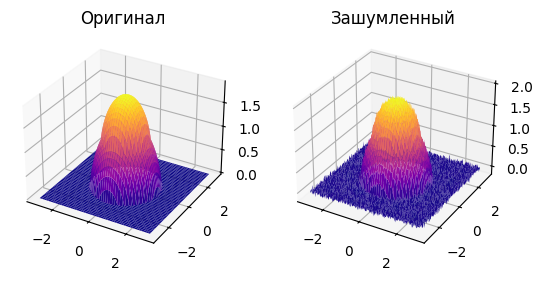

In [109]:
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
surf1 = ax.plot_surface(X, Y, z, cmap='plasma')
ax.set_title('Оригинал')
# ax.set_zlim([0, np.max(fm)])
# ax.view_init(30, -120)
# fig.colorbar(surf1, location='bottom', shrink=0.6, aspect=7)

ax = fig.add_subplot(122, projection='3d')
surf2 = ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_title('Зашумленный')
# ax.set_zlim([0, np.max((z_approx - offs))])
# ax.view_init(30, -120)
# fig.colorbar(surf2, location='bottom', shrink=0.6, aspect=7)
plt.show()

Найдено ступенек: 21
Радиусы ступеней: [1.146 1.174 1.218 1.229 1.223 1.229 1.279 1.364 1.83  1.783 1.779 1.785
 1.784 1.777 1.814 1.961 3.112 4.09  3.712 5.192 8.726]


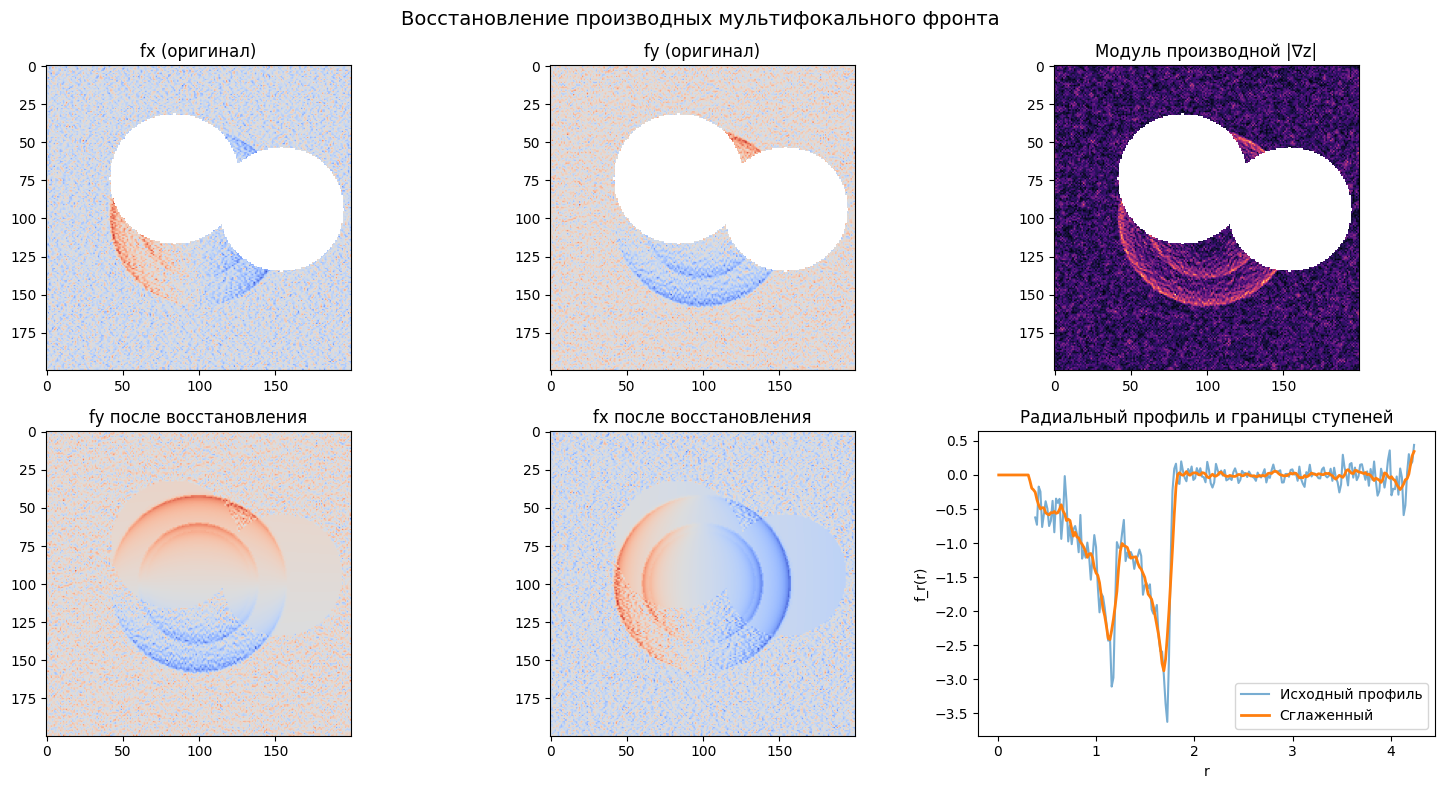

RMS ошибки на восстановленных участках (fx,fy): 1.3344194361715982


In [110]:
# вычисляем аналитические fx, fy с вашими функциями (предполагается, что fx, fy функции
# названы fx (для частной по x) и fy (для y) — в вопросе они есть)
Fx = fy(Z, N, edge)  # ваша функция fx( func, pnt_cnt, edge )
Fy = fx(Z, N, edge)

# наложим рандомную маску
Fx_masked, Fy_masked, mask = random_mask_matrices(Fx, Fy, null_fraction=0.15, seed=61)

# восстановим
Fx_filled, Fy_filled, info = fill_nan_multifocal_from_derivatives_viz(Fx_masked, Fy_masked, X, Y,
                                                                   nbins=240, smooth_win=7,
                                                                   edge_threshold_factor=1.2,
                                                                   verbose=True)

# Теперь можно сравнить восстановленные с оригиналом (например, RMS на замаскированных участках)
valid_mask = mask  # места, которые были выбиты
err_fx = Fx_filled[valid_mask] - Fx[valid_mask]
err_fy = Fy_filled[valid_mask] - Fy[valid_mask]
rms = np.sqrt(np.nanmean(err_fx**2 + err_fy**2))
print("RMS ошибки на восстановленных участках (fx,fy):", rms)